## This notebook contains demo for our fine-tuned Analyst Tone model. We fine-tuned FinBERT model on 10,000 manually annotated analyst statements. You can use this script and infer sentiment on your customerized dataset.

In [281]:
# download pre-trained and fine-tuned weights, unzip to the working directory
# https://gohkust-my.sharepoint.com/:u:/g/personal/imyiyang_ust_hk/EQJGiEOkhIlBqlW63TbKA3gBCYgDDcHlBCB7VTXIUMmyiA

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [282]:
import sys 
print(sys.version)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [283]:
import os
import copy
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from bertModel import BertClassification, dense_opt
from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [284]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab ="finance-uncased"
vocab_path = '/Users/svetlana/Downloads/analyst_tone-2/vocab' 
pretrained_weights_path ='/Users/svetlana/Downloads/analyst_tone-2/pretrained_weights'
fine_tuned_weight_path = '/Users/svetlana/Downloads/analyst_tone-2/fine_tuned.pth'   
max_seq_length=256
device=torch.device("cpu")

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [285]:
model = BertClassification(weight_path = pretrained_weights_path, 
                           num_labels=num_labels, vocab=vocab)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/svetlana/finBERT/from git/bertModel.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.classifier.weight)


In [286]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30873, 768])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
bert.embeddings.LayerNorm.weight 	 torch.Size([768])
bert.embeddings.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.0.attention.outp

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [287]:
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location=device))
model.to(device)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BertClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


# 0 is neutral, 1 is positive, and 2 is negative 

In [288]:
import glob
text_path = '/Users/svetlana/Desktop/Creation/Ventas 06112020'
files = glob.glob(text_path)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [290]:
for file in files:
    with open(file) as f:
        sentences = f.readlines()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [291]:
sentences

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['\ufeffHitachi and SBI, the largest state-owned commercial bank in India,\n',
 'enter into Joint Venture to accelerate Digital Payments in India\n',
 'Partnership to establish a state-of-the-art card acceptance\n',
 'and future ready digital payments platform\n',
 'MUMBAI, October 29, 2018 --- Hitachi, Ltd. (TSE: 6501, "Hitachi") today announced that Hitachi Payment Services Pvt. Ltd. ("Hitachi Payments"), a wholly-owned subsidiary based in India of Hitachi, and State Bank of India ("SBI") have signed a definitive agreement to enter into a joint venture for the establishment of a state-of-the-art card acceptance and future ready digital payments platform for India.\n',
 'It is planned that Hitachi Payments will invest [26%] to SBI Payment Services Pvt. Ltd. ("SBI Payment"), a wholly-owned subsidiary of SBI, and through this investment, SBI Payment will be a joint venture between both parties. Both parties will proceed to apply for regulatory approvals. \n',
 'Financial services market

In [292]:
tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, do_basic_tokenize = True)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [293]:
model.eval()
for sent in sentences: 
    tokenized_sent = tokenizer.tokenize(sent)
    if len(tokenized_sent) > max_seq_length:
        tokenized_sent = tokenized_sent[:max_seq_length]
    
    ids_review  = tokenizer.convert_tokens_to_ids(tokenized_sent)
    mask_input = [1]*len(ids_review)        
    padding = [0] * (max_seq_length - len(ids_review))
    ids_review += padding
    mask_input += padding
    input_type = [0]*max_seq_length
    
    input_ids = torch.tensor(ids_review).to(device).reshape(-1, 256)
    attention_mask =  torch.tensor(mask_input).to(device).reshape(-1, 256)
    token_type_ids = torch.tensor(input_type).to(device).reshape(-1, 256)
    
    with torch.set_grad_enabled(False):
        outputs = model(input_ids, token_type_ids, attention_mask)
        outputs = F.softmax(outputs,dim=1)
        print(sent, '\nFinBERT predicted sentiment: ', labels[torch.argmax(outputs).item()], '\n')

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


﻿Hitachi and SBI, the largest state-owned commercial bank in India,
 
FinBERT predicted sentiment:  neutral 

enter into Joint Venture to accelerate Digital Payments in India
 
FinBERT predicted sentiment:  neutral 

Partnership to establish a state-of-the-art card acceptance
 
FinBERT predicted sentiment:  neutral 

and future ready digital payments platform
 
FinBERT predicted sentiment:  positive 

MUMBAI, October 29, 2018 --- Hitachi, Ltd. (TSE: 6501, "Hitachi") today announced that Hitachi Payment Services Pvt. Ltd. ("Hitachi Payments"), a wholly-owned subsidiary based in India of Hitachi, and State Bank of India ("SBI") have signed a definitive agreement to enter into a joint venture for the establishment of a state-of-the-art card acceptance and future ready digital payments platform for India.
 
FinBERT predicted sentiment:  neutral 

It is planned that Hitachi Payments will invest [26%] to SBI Payment Services Pvt. Ltd. ("SBI Payment"), a wholly-owned subsidiary of SBI, and th

# Adding LDA

In [294]:
import csv
import re
os.getcwd()
import io

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [295]:
dirpath = r'/Users/svetlana/Desktop/Creation/'
out_file = 'log_creation.csv'
with open(out_file, 'w') as outfile:
    csvout = csv.writer(outfile)

    files = [name for name in os.listdir(dirpath)
        if name.endswith('txt')]

    for file in files:
        with open(dirpath + '/' + file) as in_file:
            stripped = (line.strip() for line in in_file)
            lines = (line.split(",") for line in stripped if line)
            csvout.writerow([" ".join([line.strip() for line in in_file])])

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [296]:
import spacy
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [297]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/svetlana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [298]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svetlana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [299]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [300]:
en_stop.add('joint')
en_stop.add('venture')
en_stop.add(' ')
print(len(en_stop))

182


/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [301]:
text_data = []
with open(out_file) as f:
    for line in f:
        tokens = prepare_text_for_lda(line)
        text_data.append(tokens)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [302]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
dictionary.filter_extremes(no_below=6, no_above=1.0)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [303]:
import gensim
NUM_TOPICS = 6
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, random_state=1, passes=50, alpha = 'auto')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.020*"technology" + 0.018*"company" + 0.017*"business" + 0.015*"million" + 0.015*"production" + 0.015*"partner" + 0.014*"investment" + 0.013*"create" + 0.013*"market" + 0.010*"provide"')
(1, '0.055*"company" + 0.029*"combine" + 0.021*"customer" + 0.021*"transaction" + 0.020*"business" + 0.019*"billion" + 0.015*"expect" + 0.014*"create" + 0.014*"share" + 0.012*"include"')
(2, '0.040*"investment" + 0.025*"project" + 0.021*"development" + 0.018*"capital" + 0.017*"market" + 0.015*"solution" + 0.015*"partner" + 0.013*"credit" + 0.013*"provide" + 0.012*"partnership"')
(3, '0.033*"energy" + 0.026*"facility" + 0.025*"technology" + 0.022*"production" + 0.020*"product" + 0.019*"business" + 0.019*"agreement" + 0.018*"company" + 0.016*"develop" + 0.016*"capacity"')
(4, '0.050*"services" + 0.044*"payment" + 0.038*"medium" + 0.038*"digital" + 0.029*"company" + 0.022*"group" + 0.021*"platform" + 0.020*"technology" + 0.018*"financial" + 0.018*"business"')
(5, '0.046*"brand" + 0.046*"consumer" + 

In [304]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
#import pyLDAvis.gensim
#lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
#pyLDAvis.display(lda_display)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [305]:
print(topics)

[(0, '0.020*"technology" + 0.018*"company" + 0.017*"business" + 0.015*"million" + 0.015*"production" + 0.015*"partner" + 0.014*"investment" + 0.013*"create" + 0.013*"market" + 0.010*"provide"'), (1, '0.055*"company" + 0.029*"combine" + 0.021*"customer" + 0.021*"transaction" + 0.020*"business" + 0.019*"billion" + 0.015*"expect" + 0.014*"create" + 0.014*"share" + 0.012*"include"'), (2, '0.040*"investment" + 0.025*"project" + 0.021*"development" + 0.018*"capital" + 0.017*"market" + 0.015*"solution" + 0.015*"partner" + 0.013*"credit" + 0.013*"provide" + 0.012*"partnership"'), (3, '0.033*"energy" + 0.026*"facility" + 0.025*"technology" + 0.022*"production" + 0.020*"product" + 0.019*"business" + 0.019*"agreement" + 0.018*"company" + 0.016*"develop" + 0.016*"capacity"'), (4, '0.050*"services" + 0.044*"payment" + 0.038*"medium" + 0.038*"digital" + 0.029*"company" + 0.022*"group" + 0.021*"platform" + 0.020*"technology" + 0.018*"financial" + 0.018*"business"'), (5, '0.046*"brand" + 0.046*"consum

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [306]:
ldamodel.print_topics(num_topics=NUM_TOPICS, num_words=10)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.020*"technology" + 0.018*"company" + 0.017*"business" + 0.015*"million" + 0.015*"production" + 0.015*"partner" + 0.014*"investment" + 0.013*"create" + 0.013*"market" + 0.010*"provide"'),
 (1,
  '0.055*"company" + 0.029*"combine" + 0.021*"customer" + 0.021*"transaction" + 0.020*"business" + 0.019*"billion" + 0.015*"expect" + 0.014*"create" + 0.014*"share" + 0.012*"include"'),
 (2,
  '0.040*"investment" + 0.025*"project" + 0.021*"development" + 0.018*"capital" + 0.017*"market" + 0.015*"solution" + 0.015*"partner" + 0.013*"credit" + 0.013*"provide" + 0.012*"partnership"'),
 (3,
  '0.033*"energy" + 0.026*"facility" + 0.025*"technology" + 0.022*"production" + 0.020*"product" + 0.019*"business" + 0.019*"agreement" + 0.018*"company" + 0.016*"develop" + 0.016*"capacity"'),
 (4,
  '0.050*"services" + 0.044*"payment" + 0.038*"medium" + 0.038*"digital" + 0.029*"company" + 0.022*"group" + 0.021*"platform" + 0.020*"technology" + 0.018*"financial" + 0.018*"business"'),
 (5,
  '0.046*"brand

In [307]:
ldamodel.log_perplexity(corpus)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-5.577324668137916

In [308]:
import numpy as np
import pandas as pd
import tqdm
from gensim.models.coherencemodel import CoherenceModel

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [309]:
cm = CoherenceModel(model=ldamodel, texts=text_data, corpus=corpus, dictionary = dictionary, coherence='c_v')
coherence = cm.get_coherence()
print(coherence)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.3234008393505779


In [310]:
limit=30
start=1
step=1
texts = text_data
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(1,30,1):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=25, alpha = 'asymmetric')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [311]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=1, 
                                                        limit=10, step=1)
print(model_list)
print(coherence_values)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[<gensim.models.ldamodel.LdaModel object at 0x7f93c8735080>, <gensim.models.ldamodel.LdaModel object at 0x7f93c87355c0>, <gensim.models.ldamodel.LdaModel object at 0x7f937af78048>, <gensim.models.ldamodel.LdaModel object at 0x7f937af6bf28>, <gensim.models.ldamodel.LdaModel object at 0x7f93e82e3da0>, <gensim.models.ldamodel.LdaModel object at 0x7f93c9f8d9e8>, <gensim.models.ldamodel.LdaModel object at 0x7f937af719e8>, <gensim.models.ldamodel.LdaModel object at 0x7f937af51f60>, <gensim.models.ldamodel.LdaModel object at 0x7f943d340160>, <gensim.models.ldamodel.LdaModel object at 0x7f937af63780>, <gensim.models.ldamodel.LdaModel object at 0x7f937af58978>, <gensim.models.ldamodel.LdaModel object at 0x7f93f86f4da0>, <gensim.models.ldamodel.LdaModel object at 0x7f93c9f6cdd8>, <gensim.models.ldamodel.LdaModel object at 0x7f937af31358>, <gensim.models.ldamodel.LdaModel object at 0x7f937af56470>, <gensim.models.ldamodel.LdaModel object at 0x7f937af517b8>, <gensim.models.ldamodel.LdaModel object

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


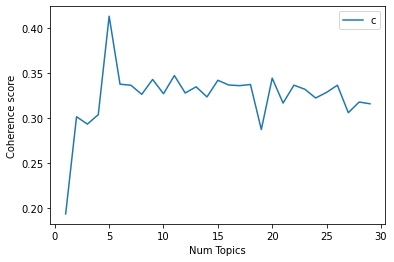

In [312]:
import matplotlib.pyplot as plt
x = range(1,30,1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("cv"), loc='best')
plt.show()

# Extracting financial data with yahoo_fin

In [313]:
import yahoo_fin

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [314]:
from yahoo_fin.stock_info import *
ventas_data = get_data('VTR', start_date = '11/05/2020' , end_date = '11/10/2020')

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [315]:
print(ventas_data['adjclose'])

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020-11-05    40.741283
2020-11-06    39.274914
2020-11-09    46.418510
Name: adjclose, dtype: float64
